# 複数銘柄・複数戦略のシグナル表示（ブログ修正コード）

In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_ta as ta
import talib

In [2]:
# クロスオーバーとクロスアンダー及びしきい値クロス関数
def crossover(series1, series2):
    # Ensure the inputs are numpy arrays for element-wise operations
    series1 = np.array(series1)
    series2 = np.array(series2)
    # Calculate the crossover: (previous series1 < previous series2) and (current series1 > current series2)
    cross = (series1[:-1] < series2[:-1]) & (series1[1:] > series2[1:])
    # Append a False at the start since there is no crossover detection at the first element
    return np.append(False, cross)

def overthreshold(series1, x):
    series1 = np.array(series1)
    series2 = np.full(series1.shape[0], x)
    # Calculate the crossover: (previous series1 < previous series2) and (current series1 > current series2)
    cross = (series1[:-1] < series2[:-1]) & (series1[1:] > series2[1:])
    # Append a False at the start since there is no crossover detection at the first element
    return np.append(False, cross)

def crossunder(series1, series2):
    # Ensure the inputs are numpy arrays for element-wise operations
    series1 = np.array(series1)
    series2 = np.array(series2)
    # Calculate the crossunder: (previous series1 > previous series2) and (current series1 < current series2)
    cross = (series1[:-1] > series2[:-1]) & (series1[1:] < series2[1:])
    # Append a False at the start since there is no crossunder detection at the first element
    return np.append(False, cross)

def underthreshold(series1, x):
    series1 = np.array(series1)
    series2 = np.full(series1.shape[0], x)
    # Calculate the crossunder: (previous series1 > previous series2) and (current series1 < current series2)
    cross = (series1[:-1] > series2[:-1]) & (series1[1:] < series2[1:])
    # Append a False at the start since there is no crossunder detection at the first element
    return np.append(False, cross)

In [4]:
# 単純移動平均の長短クロス及びMACDとMACD_signalのクロスによるシグナル判定
def smamacd(df,smaShort=5,smaLong=25,\
           macdFastLength=12,macdSlowLength=26,macdSignalSmoothing=9):
    # create dataframe
    df1 = df.copy()
    # calculate simple moving average
    df1["sma_short"] = talib.SMA(df1["Close"], timeperiod=smaShort)
    df1["sma_long"] = talib.SMA(df1["Close"], timeperiod=smaLong)
    # SMA crossover conditions
    df1['smaCrossUp'] = crossover(df1['sma_short'], df1['sma_long'])
    df1['smaCrossDown'] = crossunder(df1['sma_short'], df1['sma_long'])
    # BUY and SELL signal conditions
    df1['MA_buySignal'] = df1['smaCrossUp']
    df1['MA_sellSignal'] = df1['smaCrossDown']
    # calculate MACD
    df1["macd"], df1["macdsignal"], df1["macdhist"] = talib.MACD(df1["Close"],\
            fastperiod=macdFastLength, slowperiod=macdSlowLength, signalperiod=macdSignalSmoothing)
    # MACD crossover conditions
    df1['macdCrossUp'] = crossover(df1['macd'], df1['macdsignal'])
    df1['macdCrossDown'] = crossunder(df1['macd'], df1['macdsignal'])
    # BUY and SELL signal conditions
    df1['MACD_buySignal'] = df1['macdCrossUp']
    df1['MACD_sellSignal'] = df1['macdCrossDown']
    # return dataframe
    return df1.loc[:, ['Date','ticker','MA_buySignal','MA_sellSignal','MACD_buySignal','MACD_sellSignal']]

In [5]:
# Kaabar氏の単純戦略によるシグナル判定
def kaabarsimple(df,rsiLength=14,rsiLowerThreshold=30,\
        rsiUpperThreshold=70,bollingerLength=20):
    # create dataframe
    df1 = df.copy()
    # calculate RSI
    df1["RSI"] = talib.RSI(df1["Close"], timeperiod=rsiLength)
    # calculate Bollinger Bands
    df1["upperband"], df1["middleband"], df1["lowerband"] = talib.BBANDS(df1["Close"], \
                        timeperiod=bollingerLength, nbdevup=2, nbdevdn=2, matype=0)
    # Bollinger crossover conditions
    df1['bollCrossUp'] = crossover(df1['Close'], df1['lowerband'])
    df1['bollCrossDown'] = crossunder(df1['Close'], df1['upperband'])
    # RSI crossover condition
    df1['rsiCrossUp'] = overthreshold(df1['RSI'], rsiLowerThreshold)
    df1['rsiCrossDown'] = underthreshold(df1['RSI'], rsiUpperThreshold)
    # BUY signal conditions
    df1['KB_buySignal'] = df1['rsiCrossUp'] & df1['bollCrossUp']
    # SELL signal conditions
    df1['KB_sellSignal'] = df1['rsiCrossDown'] & df1['bollCrossDown']
    # return dataframe
    return df1.loc[:, ['Date','ticker','KB_buySignal','KB_sellSignal']]

In [6]:
# 銘柄のリスト
list_ticker = ['9983.T', '9984.T']
# str_prodはデータを取得する期間（例: 1d、5d、1mo、3mo、1y、2y、5y、10y、ytd、max）
str_prod = "24mo"
# str_itvlはデータの間隔（例: 1m、2m、5m、15m、30m、60m、90m、1h、1d、5d、1wk、1mo、3mo）
str_itvl = "1d"

In [7]:
# 各銘柄についてシグナル判定を行い結果を縦連結する
df0 = pd.DataFrame()
for symbol in list_ticker:
    # yahooサイトからデータをダウンロード
    data = yf.download(symbol, period=str_prod, interval=str_itvl, multi_level_index=False)
    data['ticker'] = symbol
    df = data.reset_index()
    # SMA/MACD戦略によるシグナル判定の実施
    df_SmaMacd = smamacd(df)
    # シグナル判定結果を元データに横連結する
    df = df.merge(df_SmaMacd, how="inner", on=['Date','ticker'])
    # Sofien Kaabar氏のsimple戦略によるシグナル判定の実施
    df_KaabarSimple = kaabarsimple(df)
    # シグナル判定結果を元データに横連結する
    df = df.merge(df_KaabarSimple, how="inner", on=['Date','ticker'])
    # 一銘柄のシグナル判定結果を元のデータに縦連結する
    df0 = pd.concat([df0,df],axis=0)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


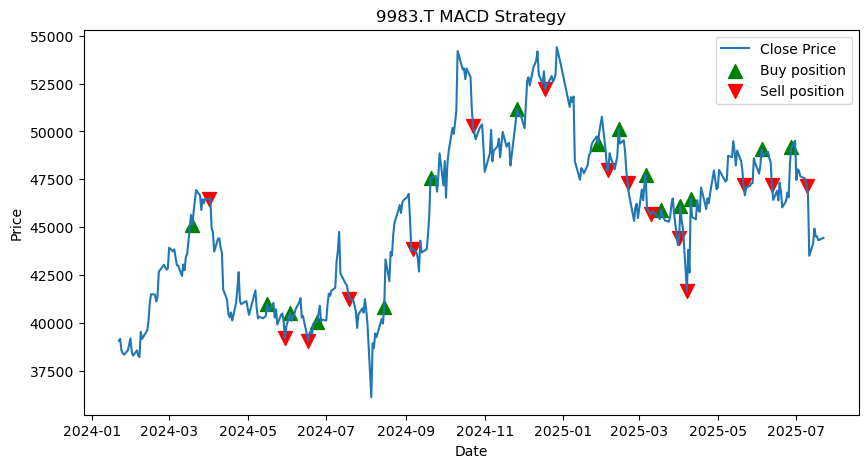

In [8]:
def signal_plot(df0, ticker, str_osc, str_title):
    df = df0[df0['ticker'].str.contains(ticker)]
    # 終値と各種指標のプロット
    plt.figure(figsize=(10, 5))
    plt.plot(df['Date'], df['Close'], label='Close Price')
    # 売買ポジションのプロット
    plt.scatter(df['Date'][df[f"{str_osc}_buySignal"]], df['Close'][df[f"{str_osc}_buySignal"]], color='green', label='Buy position', marker="^", s=100)
    plt.scatter(df['Date'][df[f"{str_osc}_sellSignal"]], df['Close'][df[f"{str_osc}_sellSignal"]], color='red', label='Sell position', marker="v", s=100)
    # 凡例の表示
    plt.legend()
    # 軸ラベルとタイトル
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(focus_ticker + f" {str_title} Strategy")
    # チャートの表示
    plt.show()

focus_ticker = '9983.T'
signal_plot(df0, focus_ticker, 'MACD', 'MACD')

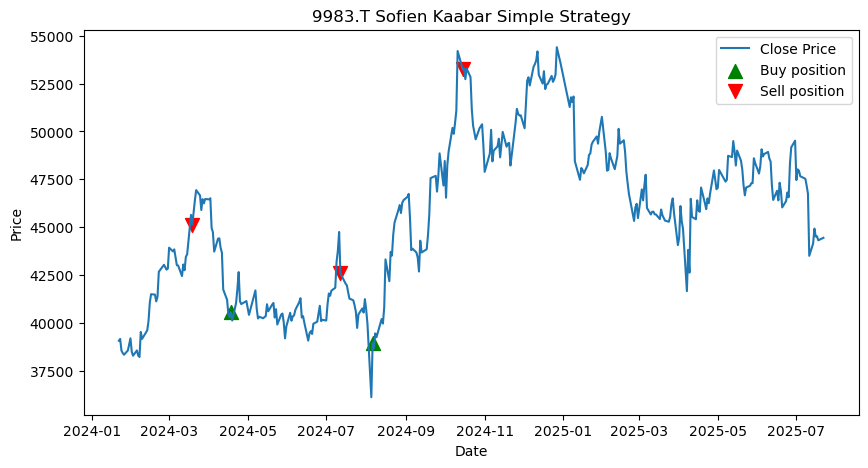

In [9]:
focus_ticker = '9983.T'
signal_plot(df0, focus_ticker, 'KB', 'Sofien Kaabar Simple')